#### ViT Model for Classification of All Defects (including nones)
ViT Model from Google [paper](https://arxiv.org/abs/2010.11929)
using Keras implementation from faustomorales [GitHub](https://github.com/faustomorales/vit-keras)

Data preprocessing:
- Resized to 224x224 with no filters
- None is randomly undersampled to 30,000.

ViT model:
- Size = B16
- Patch size = 16
- Using included top

In [ ]:
#### RUN VIT REQUIREMENTS NOTEBOOK FIRST ####
# need to install required packages to environment before running the model

In [1]:
# import libraries
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import datasets, layers, models, losses, optimizers, regularizers, callbacks
from vit_keras import vit, utils

import os
import time
import numpy as np
import pandas as pd
import cv2
from skimage.morphology import skeletonize, thin

import helpers as helper
from keras_model_s3_wrapper import *

import boto3
import pickle5 as pickle
s3 = boto3.resource('s3')
bucket_name = 'wafer-capstone'
my_bucket = s3.Bucket(bucket_name)

In [2]:
tf.__version__

'2.4.0'

In [3]:
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.compat.v1.Session(config=config)

In [4]:
tf.config.list_physical_devices(device_type=None)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:3', device_type='GPU')]

In [5]:
# specify variables
path = 'processed_data/vit'
filename = 'WM-clean-vit224-undersampled'

result_path = 'results_vit'
model_id = 'vit-b16'
data_id = '224-undersampled'
note = '-p3' # -optional

In [6]:
!free -h

             total       used       free     shared    buffers     cached
Mem:          240G        18G       221G        32M       284M        14G
-/+ buffers/cache:       3.1G       236G
Swap:           0B         0B         0B


In [7]:
# load dataset
from io import BytesIO
start = time.time()

data_key = f'{path}/{filename}.npz'
data_obj = my_bucket.Object(data_key).get()['Body'].read()
data = np.load(BytesIO(data_obj), allow_pickle=True)

print('Wall time: {:.3f} seconds'.format(time.time() - start))
data.files

Wall time: 3.029 seconds


['ids', 'labels', 'dataset', 'wafermap']

In [8]:
!free -h

             total       used       free     shared    buffers     cached
Mem:          240G        18G       221G        32M       284M        14G
-/+ buffers/cache:       3.4G       236G
Swap:           0B         0B         0B


#### Data set-up

In [9]:
# prepare inputs
start = time.time()

x_train = data['wafermap'][data['dataset']=='train']
x_val = data['wafermap'][data['dataset']=='dev']
x_test = data['wafermap'][data['dataset']=='test']

print('Wall time: {:.3f} seconds'.format(time.time() - start))
print(f'Train: {x_train.shape}')
print(f'Dev: {x_val.shape}')
print(f'Test: {x_test.shape}')

Wall time: 127.016 seconds
Train: (47863, 224, 224, 3)
Dev: (25942, 224, 224, 3)
Test: (25943, 224, 224, 3)


In [10]:
# prepare labels for supervised learning
# note: make sure labels are integers if using sparse categorical cross entropy
start = time.time()

y_train = data['labels'][data['dataset']=='train']
y_val = data['labels'][data['dataset']=='dev']
y_test = data['labels'][data['dataset']=='test']

print("Wall time: {:.2f} seconds".format(time.time() - start))
# sanity check
# expected: type = int, min = 0, max = 8
print(type(y_train[0]))
print(min(y_train), min(y_val), min(y_test))
print(max(y_train), max(y_val), max(y_test))

Wall time: 0.03 seconds
<class 'numpy.uint8'>
0 0 0
8 8 8


In [11]:
!free -h

             total       used       free     shared    buffers     cached
Mem:          240G        32G       207G        32M       284M        14G
-/+ buffers/cache:        17G       222G
Swap:           0B         0B         0B


#### Model

In [24]:
# fine-tune using pre-trained vit model
image_size = 224
vit_model = vit.vit_b16(
    image_size=image_size,
    activation='sigmoid',
    pretrained=True,
    include_top=False,
    pretrained_top=False,
    classes=9
)

# classification head similar to yu classify model
model = models.Sequential()
model.add(vit_model)
model.add(layers.Dense(384, activation='sigmoid', kernel_regularizer=regularizers.l2(0.000001)))
model.add(layers.Dense(96, activation='sigmoid', kernel_regularizer=regularizers.l2(0.000001)))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(9, activation='softmax'))

model.summary()

/home/ec2-user/anaconda3/envs/amazonei_tensorflow2_p36/lib/python3.6/site-packages/vit_keras/utils.py:83: UserWarning: Resizing position embeddings from 24, 24 to 14, 14
  UserWarning,


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vit-b16 (Functional)         (None, 768)               85798656  
_________________________________________________________________
dense (Dense)                (None, 384)               295296    
_________________________________________________________________
dense_1 (Dense)              (None, 96)                36960     
_________________________________________________________________
dropout (Dropout)            (None, 96)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 9)                 873       
Total params: 86,131,785
Trainable params: 86,131,785
Non-trainable params: 0
_________________________________________________________________


In [25]:
# set model optimizer and metrics
opt = optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer='adam', loss=losses.sparse_categorical_crossentropy, metrics=['accuracy'])

In [26]:
!free -h

             total       used       free     shared    buffers     cached
Mem:          240G        51G       188G        36M       289M        15G
-/+ buffers/cache:        36G       203G
Swap:           0B         0B         0B


In [27]:
# run model
start = time.time()

history = model.fit(x_train, y_train, validation_data=(x_val, y_val), batch_size=32, epochs=1)

print("Wall time: {:.2f} seconds".format(time.time() - start))

1496/1496 [==============================] - 765s 500ms/step - loss: 1.0650 - accuracy: 0.7051 - val_loss: 0.3897 - val_accuracy: 0.9026
Wall time: 769.90 seconds


In [ ]:
# visualize accuracy and loss history
fig, axs = plt.subplots(2, 1, figsize=(15,15))

axs[0].plot(history.history['loss'])
axs[0].plot(history.history['val_loss'])
axs[0].title.set_text('Training Loss vs Validation Loss')
axs[0].legend(['Train', 'Val'])

axs[1].plot(history.history['accuracy'])
axs[1].plot(history.history['val_accuracy'])
axs[1].title.set_text('Training Accuracy vs Validation Accuracy')
axs[1].legend(['Train', 'Val'])

#### Model results

In [28]:
# save model to S3
#s3_save_keras_model(model, f'{model_id}-{data_id}{note}')
s3_save_keras_model(model, 'vit-trial')

INFO:tensorflow:Assets written to: /tmp/tmpgc_lglga/vit-trial/assets


INFO:tensorflow:Assets written to: /tmp/tmpgc_lglga/vit-trial/assets


In [29]:
# compute model results on test set
start = time.time()
results = model.evaluate(x_test, y_test)
print("Wall time: {:.2f} seconds".format(time.time() - start))
print(results)

811/811 [==============================] - 117s 145ms/step - loss: 0.3857 - accuracy: 0.9045
Wall time: 120.33 seconds
[0.38567492365837097, 0.904482901096344]


In [30]:
# generate predictions for model analysis
start = time.time()
y_pred = model.predict(x_test)
y_max = np.argmax(y_pred, axis=1).astype(np.uint8)
predictions = [y_max, y_pred]
print("Wall time: {:.2f} seconds".format(time.time() - start))

Wall time: 121.05 seconds


In [31]:
# save predictions to local instance
# with open(f'{result_path}/{model_id}-{data_id}{note}.pkl', "wb") as f:
#     pickle.dump(predictions, f)
with open('vit-trial.pkl', "wb") as f:
    pickle.dump(predictions, f)

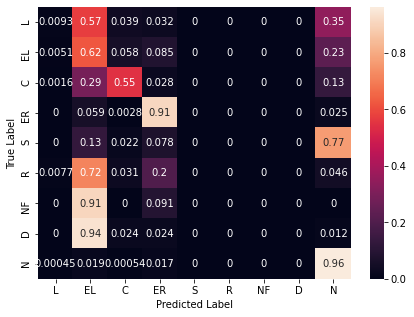

In [32]:
# plot confusion matrix
helper.plot_confusion_matrix(y_test, y_max, mode='all', normalize=True)

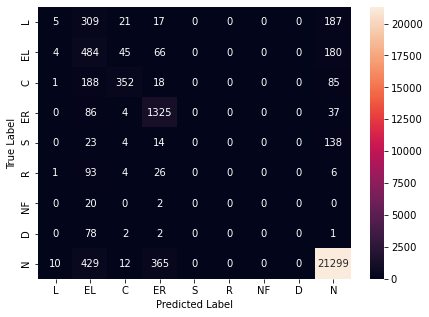

In [33]:
# plot confusion matrix counts
helper.plot_confusion_matrix(y_test, y_max, mode='all', normalize=False)